# TCC Augusto e Ícaro
## Modelo de automatização das Heurísticas de Nielsen para comentários em reviews de Apps

* Versão 0.3.0
* Bibliotecas utilizadas: pandas, numpy, texthero, ntlk e corpus do ntlk em português
* Dataset utilizado: dataset_v9.csv
* Data: 04/07/2020

### Objetivos, incrementos e correções:

* Encapsulamento da pipeline de pre-processamento
* Utilizando dataset com classificação revisada para melhor acurácia
* Aumento dos pesos de termos classificados como usabilidade
* Foco em detalhar e evoluir o dicionário de radicais classificados

In [665]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install texthero 
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install sklearn

Requirement already up-to-date: pip in /home/icaro/.pyenv/versions/3.7.3/lib/python3.7/site-packages (20.2.1)


  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=8af4c8b9e3e6ecd9548b79d553ec0fcf99b8a44ed5b85391e81df6bd32ed3f38
  Stored in directory: /home/icaro/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [753]:
import pandas as pd
import texthero as hero
import nltk
from nltk.corpus import stopwords
import numpy as np
# nltk.download()

## Pré-processamento

In [754]:
DROPLIST_FILENAME='droplist.0.2.0.txt'
MODEL_FILENAME='model_v0.2.0.json'
DATASET_FILENAME='reviews_v9.csv'

In [755]:
def pre_process(df_path, df_cols):
    df = pd.read_csv(df_path, index_col=False, usecols=df_cols)
    df = df[df['is_classified']==True]
    df = df.rename(columns={'Text': 'text'})
    df['text'] = hero.preprocessing.clean(df['text'])
    pt_stopwords = stopwords.words('portuguese')
    df['text'] = hero.remove_stopwords(df['text'], stopwords=pt_stopwords)
    df['text'] = hero.stem(df['text'], language='portuguese')
    df['text'] = hero.tokenize(df['text'])
    df['class_name'] = df.apply(lambda row: 'usability' if row['is_usability'] else 'not_usability', axis=1)
    df = df.drop('is_usability', 1)
    df = df.to_dict('records')
    return df    

In [756]:
def split_train_test(df, train_size):
    
    df_usa = [item for item in df if item['class_name'] == 'usability']
    df_not_usa = [item for item in df if item not in df_usa]
    
    train_usa, test_usa = np.split(df_usa, [int(len(df_usa)*train_size)])
    train_not_usa, test_not_usa = np.split(df_not_usa, [int(len(df_not_usa)*train_size)])
    
    return np.concatenate([train_usa,train_not_usa]), np.concatenate([test_usa,test_not_usa])

In [757]:
df = pre_process(DATASET_FILENAME, ['ID', 'Text', 'is_usability', 'is_classified'])
train_dataset, test_dataset = split_train_test(df, train_size=0.7)

In [758]:
print(f'train: {len(train_dataset)} test: {len(test_dataset)}')

train: 650 test: 280


In [759]:
print(f'[info] total usability train data {sum(value["class_name"] == "usability" for value in train_dataset)}')
print(f'[info] total not_usability train data {sum(value["class_name"] == "not_usability" for value in train_dataset)}')
print(f'[info] total usability test data {sum(value["class_name"] == "usability" for value in test_dataset)}')
print(f'[info] total not_usability test data {sum(value["class_name"] == "not_usability" for value in test_dataset)}')

[info] total usability train data 497
[info] total not_usability train data 153
[info] total usability test data 214
[info] total not_usability test data 66


## Classificador

In [760]:
def train(training_data):
    corpus_words = {}
    for data in training_data: 
        class_name = data['class_name']
        frase = data['text']
        if class_name not in list(corpus_words.keys()):
            corpus_words[class_name] = {}
        for word in frase:
            if word not in list(corpus_words[class_name].keys()):
                corpus_words[class_name][word] = 1
            else:
                corpus_words[class_name][word] += 1
    return corpus_words

In [761]:
def drop_low_score(corpus_words, min_value, by_key):
    fitered_dict = {}
    for k in corpus.keys():
        if by_key:
            if k == by_key:
                fitered_dict.update({k: { key:value for (key,value) in corpus[k].items() if value > min_value }})
            else:
                fitered_dict.update({k: { key:value for (key,value) in corpus[k].items() }})
        else:
            fitered_dict.update({k: { key:value for (key,value) in corpus[k].items() if value > min_value }})
    return fitered_dict

In [762]:
def classificate(corpus, sentence):
    def calculate_class_score(corpus_words, sentence, class_name):
        score = 0 
        for word in sentence:
            if word in corpus_words[class_name]:
                score += corpus_words[class_name][word]
        return score
    classifications = []
    for class_name in corpus.keys():
        classifications.append({'class_name': class_name, 'score': calculate_class_score(corpus, sentence, class_name)})    
    return classifications

In [763]:
def normalize_scores(classification):
    total_score = sum(score['score'] for score in classification['scores'])
    if total_score != 0:
        for score in classification['scores']:
            score['score'] = score['score']/total_score
    return classification

In [764]:
def boost_score_targets(corpus, targets, boost_val):
    boosted_dict = {}
    for k in corpus.keys():
        if k in targets:
            boosted_dict.update({k: { key:value*boost_val for (key,value) in corpus[k].items() }})
        else:
            boosted_dict.update({k: { key:value for (key,value) in corpus[k].items() }})
    return boosted_dict

In [765]:
def get_accuracy(classifications):
    accuracies = {
        'usability': 0,
        'not_usability': 0,
        'draws': 0
    }
    class_usa = []
    for classification in classifications:
        scores = [item['score'] for item in classification['scores']]
        is_draw = len(set(scores)) == 1
        if is_draw:
            accuracies['draws'] +=1
            continue
        highest_score = max(classification['scores'], key=lambda x:x['score'])
        is_draw = False
        if classification['test_data']['class_name'] == highest_score['class_name']:
            accuracies[highest_score['class_name']] += 1
            if(classification['test_data']['class_name']=='usability'):
                class_usa.append(classification)
        else:
            if(classification['test_data']['class_name']=='not_usability'):
                print(classification)
    return accuracies, class_usa

In [766]:
def drop_unwanted_words(corpus, droplist):
    filtered_dict = {}
    for k in corpus.keys():
        filtered_dict.update({k: { key:value for (key,value) in corpus[k].items() if key not in droplist }})
    return filtered_dict

In [767]:
droplist = open(DROPLIST_FILENAME).read().splitlines()
corpus = train(train_dataset)
# corpus = drop_low_score(corpus, 10, 'usability') # magic number
# corpus = drop_low_score(corpus, 10, 'not_usability') # magic number
# corpus = drop_unwanted_words(corpus, droplist)
corpus = boost_score_targets(corpus, ['usability'], 1) # magic number
corpus = boost_score_targets(corpus, ['not_usability'], 20) # magic number

In [768]:
for key in corpus.keys():
    print(f' total words for {key}: {len(corpus[key].keys())} ')

 total words for usability: 820 
 total words for not_usability: 91 


In [769]:
classifications = [{'test_data': test_data, 'scores': classificate(corpus, test_data['text'])} for test_data in test_dataset]
classifications = [normalize_scores(classification) for classification in classifications]

In [770]:
accuracy, cls_usa = get_accuracy(classifications)

{'test_data': {'ID': 'gp:AOqpTOEmhvarDkCoCfNQu-lfNPAwf4Z5TsoSTiYAy7g-5EMe5jZRiy8J5K1RgZONAqQfaBlrkzxAxjVGbN097Q', 'text': ['claudi', 'faustin', 'silv'], 'is_classified': True, 'class_name': 'not_usability'}, 'scores': [{'class_name': 'usability', 'score': 1.0}, {'class_name': 'not_usability', 'score': 0.0}]}
{'test_data': {'ID': 'gp:AOqpTOGtFeGleSuBGO7J2-LkfApYVTCwreQ6DFYzcHvM2nJrAdKkzqssyd2_9UaoUKLq69MP5cI4bk3J06xTig', 'text': ['complic', 'afff'], 'is_classified': True, 'class_name': 'not_usability'}, 'scores': [{'class_name': 'usability', 'score': 1.0}, {'class_name': 'not_usability', 'score': 0.0}]}
{'test_data': {'ID': 'gp:AOqpTOEsw_yh3duqNyisljbcST0EAWAy4V9dDjBa0nXUe-M2yFgwdoZO70s8CBJwndG2m1mEjqNC9gcQqLU74g', 'text': ['nao', 'consegu', 'cadastr'], 'is_classified': True, 'class_name': 'not_usability'}, 'scores': [{'class_name': 'usability', 'score': 0.8366394399066511}, {'class_name': 'not_usability', 'score': 0.1633605600933489}]}
{'test_data': {'ID': 'gp:AOqpTOEqtzZDbJr2ZjY2WGOhi

In [771]:
print(f'Right answers Usability: {accuracy["usability"]} of {len([data for data in test_dataset if data["class_name"]=="usability"])} ({accuracy["usability"]/len([data for data in test_dataset if data["class_name"]=="usability"])})')
print(f'Right answers Not Usability: {accuracy["not_usability"]} of {len([data for data in test_dataset if data["class_name"]=="not_usability"])} ({accuracy["not_usability"]/len([data for data in test_dataset if data["class_name"]=="not_usability"])})')
print(f'Draws: {accuracy["draws"]}')

Right answers Usability: 213 of 214 (0.9953271028037384)
Right answers Not Usability: 25 of 66 (0.3787878787878788)
Draws: 3


In [772]:
# is this correct?
classifications = [{'test_data': test_data, 'scores': classificate(corpus, test_data['text'])} for test_data in df]
classifications = [normalize_scores(classification) for classification in classifications]
accuracy = get_accuracy(classifications)

{'test_data': {'ID': 'gp:AOqpTOEUCSHVdGKLJoAOML9wZpHzkD0A8Xavn9KPgidxzcGilmD8CjyuT35NYKiIQa2nk-sKYzCbu0qJsVE6dg', 'text': ['nao', 'boa'], 'is_classified': True, 'class_name': 'not_usability'}, 'scores': [{'class_name': 'usability', 'score': 0.7245179063360881}, {'class_name': 'not_usability', 'score': 0.27548209366391185}]}
{'test_data': {'ID': 'gp:AOqpTOGycTCJ9fSb3Flzi-E7KWoPeWpGhoH03kkRc5XNaa7YurpjLwVNyp-OvJPjM_QLkhaVe_nnK0DCaQR46w', 'text': ['funcion'], 'is_classified': True, 'class_name': 'not_usability'}, 'scores': [{'class_name': 'usability', 'score': 0.7802197802197802}, {'class_name': 'not_usability', 'score': 0.21978021978021978}]}
{'test_data': {'ID': 'gp:AOqpTOGyXTwzF9TQXXZPQOgXid8XoG2-tMi_SkEb2xyJutEd0JquYxnC6YJqxBtOPMo-1AFaQtpJYkb8yE055Q', 'text': ['nao', 'consegu', 'entrar'], 'is_classified': True, 'class_name': 'not_usability'}, 'scores': [{'class_name': 'usability', 'score': 0.7886393659180978}, {'class_name': 'not_usability', 'score': 0.21136063408190225}]}
{'test_data

In [773]:
print(f'Right answers Usability: {accuracy["usability"]} of {len([data for data in df if data["class_name"]=="usability"])} ({accuracy["usability"]/len([data for data in df if data["class_name"]=="usability"])})')
print(f'Right answers Not Usability: {accuracy["not_usability"]} of {len([data for data in df if data["class_name"]=="not_usability"])} ({accuracy["not_usability"]/len([data for data in df if data["class_name"]=="not_usability"])})')
print(f'Draws: {accuracy["draws"]}')

TypeError: tuple indices must be integers or slices, not str

In [ ]:
corpus

In [ ]:
texts = []
for c in df:
    texts.append(c['text'])
texts

In [774]:
documents = []
for test_data in texts:
    documents.append(' '.join(test_data))
print(documents)

['ok', 'hh', 'ok', 'top', 'boa', 'bom', 'bom', 'amo', 'boa', 'bom', 'bom', 'boa', 'gea', 'bom', '', 'bom', 'bom', 'bom', 'bom', 'bom', 'bom', 'bom', 'bom', 'top', 'ruim', 'ruim', 'joi', 'bom', 'ruim', 'ruim', 'util', 'zer', 'lix', 'lix', 'ruim', 'otim', 'otim', 'med', 'legal', 'legal', 'otim', 'bost', 'otim', 'otim', 'otim', 'otim', 'otim', 'otim', 'bost', 'pecim', 'belez', 'inutil', 'not', 'pessim', 'pessim', 'mt ruim', 'lix', 'nao boa', 'otim', 'pessim', 'mbbnb', 'pessim', 'pessim', 'pessim', 'pessim', 'pessim', 'pessim', 'horrivel', 'parabens', 'terrivel', 'horrivel', 'pessim', 'horrivel', 'horrivel', 'pessim', 'horrivel', 'excelent', 'bom', 'sim otim', 'excelent', 'parabens', 'agil', 'bom', 'bom', 'bom', 'funcion', 'bom', 'bom', 'bom', 'bom', 'bom', 'bom', 'satisfaz', 'excelent', 'gost', 'ruim', 'ruim', 'drog', 'ruim', 'acessivel', 'bom', 'bom', 'bom', 'bom', 'ruim', 'ruim', 'ruim', 'ruim', 'facil', 'otim', 'horrivel', 'bom dem', 'legal', 'pessim app', 'excelent ok', 'decepcion', '

In [782]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("10 palavras mais frequentes por cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind])

10 palavras mais frequentes por cluster:
Cluster 0:
 bom
 pessim
 ruim
 aplic
 app
 ser
 parec
 especial
 esclarecedor
 dem
 naveg
 erro
 test
 agil
 transit
 nel
 agent
 melhor
 dia
 inval
Cluster 1:
 nao
 cadastr
 senh
 consig
 ja
 acess
 recuper
 cont
 diz
 tent
 nunc
 cpf
 fiz
 faz
 email
 pra
 entrar
 aparec
 enem
 fac
Cluster 2:
 funcion
 nao
 facial
 reconhec
 pessim
 faz
 validaca
 erro
 app
 consig
 rost
 cadastr
 lix
 fac
 ruim
 facil
 identific
 consegu
 pra
 complic
Cluster 3:
 otim
 realment
 sim
 tranquil
 bom
 usar
 app
 consig
 zer
 ea
 econhec
 econm
 econom
 edit
 edson
 efetu
 eleitoral
 eficaz
 duv
 emagrec
Cluster 4:
 horrivel
 senh
 pessim
 recuper
 nao
 atrapalh
 carreg
 work
 experienc
 abre
 aplic
 centralizaca
 reculper
 vsf
 promet
 perd
 nunc
 cumpr
 nad
 acess
Cluster 5:
 nao
 app
 aplic
 pra
 faz
 fot
 consegu
 lix
 acess
 pessim
 cnh
 nad
 erro
 senh
 consig
 vid
 fic
 tod
 biometr
 tir


In [791]:
Y = vectorizer.transform(["meu cpf nao esta funcionando"])
prediction = model.predict(Y)
prediction

array([1], dtype=int32)

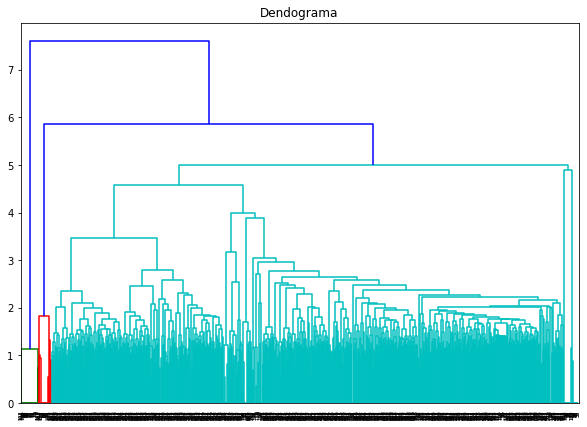

In [784]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

X = vectorizer.fit_transform(documents)

plt.figure(figsize=(10, 7))
plt.title("Dendograma")
dend = dendrogram(linkage(X.toarray(), method='ward'))

In [785]:
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
cluster.fit_predict(X.toarray())

array([0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 3, 0, 0, 3, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 4, 4, 0, 3, 4, 4, 0, 0, 0, 0, 4, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 1, 5, 0, 5, 5, 5, 5, 5,
       5, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 3, 1, 0, 0, 0, 3, 3, 3, 0, 3, 3,
       3, 3, 3, 3, 0, 0, 2, 4, 4, 0, 4, 0, 3, 3, 3, 3, 4, 4, 4, 4, 0, 1,
       0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 1, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 5, 2, 2, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 5, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       2, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 5, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2,

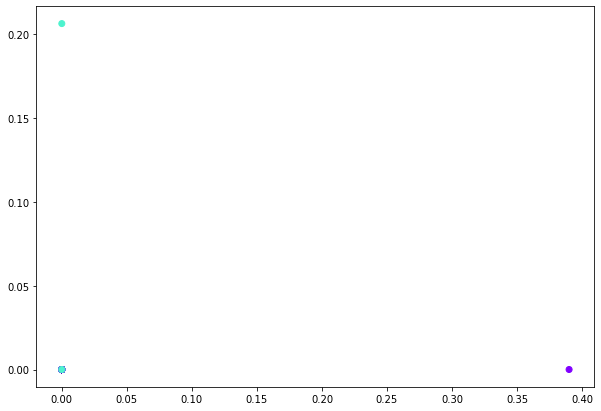

In [786]:
plt.figure(figsize=(10, 7))
plt.scatter(X.toarray()[:,0], X.toarray()[:,930], c=cluster.labels_, cmap='rainbow')
plt.show()